# Sää ja sähkö


In [1]:
import datetime as dt
import xmltodict
import pandas as pd
from catboost import Pool, CatBoostRegressor
from fmiopendata.wfs import download_stored_query
import seaborn as sns

sns.set_theme(rc={"figure.figsize": (11.7, 8.27)})


def date_range(start_date, end_date, max_days):
    current_date = start_date
    while (end_date - current_date).days >= max_days:
        chunk_end = current_date + dt.timedelta(days=max_days - 1)
        yield (current_date, chunk_end)
        current_date = chunk_end + dt.timedelta(days=1)
    yield (current_date, end_date)

# Weather data

Weather data is collected from [Finnish Meteorological Institute open data](https://en.ilmatieteenlaitos.fi/open-data) with [`fmiopendata`](https://github.com/pnuu/fmiopendata) Python library.


In [2]:
def get_weather_df(
    start_date: dt.date, end_date: dt.date, place: str = "Helsinki"
) -> pd.DataFrame:
    """Fetch weather data between given dates

    Args:
        start_date (dt.date): Start date of requested weather data
        end_date (dt.date): End date of requested weather data
        place (str, optional): Place of requested weather data. Defaults to "Helsinki".
    """
    weather_data = {}
    for start, end in date_range(start_date, end_date, 31):
        start_string = start.strftime("%Y-%m-%d") + "T00:00:00Z"
        end_string = end.strftime("%Y-%m-%d") + "T23:59:59Z"
        data_chunk = download_stored_query(
            "fmi::observations::weather::hourly::multipointcoverage",
            [
                "place=" + place,
                "starttime=" + start_string,
                "endtime=" + end_string,
            ],
        ).data
        weather_data.update(data_chunk)

    dates = []
    air_temperatures = []
    wind_speeds = []
    precipitation_amounts = []
    place_key = list(list(weather_data.values())[0].keys())[0]
    for datetime, data in weather_data.items():
        dates.append(datetime)
        air_temperatures.append(data[place_key]["Air temperature"]["value"])
        wind_speeds.append(data[place_key]["Wind speed"]["value"])
        precipitation_amounts.append(data[place_key]["Precipitation amount"]["value"])

    weather_df = pd.DataFrame(
        {
            "datetime": dates,
            "air temperatures": air_temperatures,
            "wind speeds": wind_speeds,
            "precipitation amounts": precipitation_amounts,
        }
    )

    return (weather_data, weather_df)

# Energy data

Energy data is obtained from [ENTSO-E (European Network of Transmission System Operators for Electricity) API](https://transparency.entsoe.eu/load-domain/r2/totalLoadR2/show).


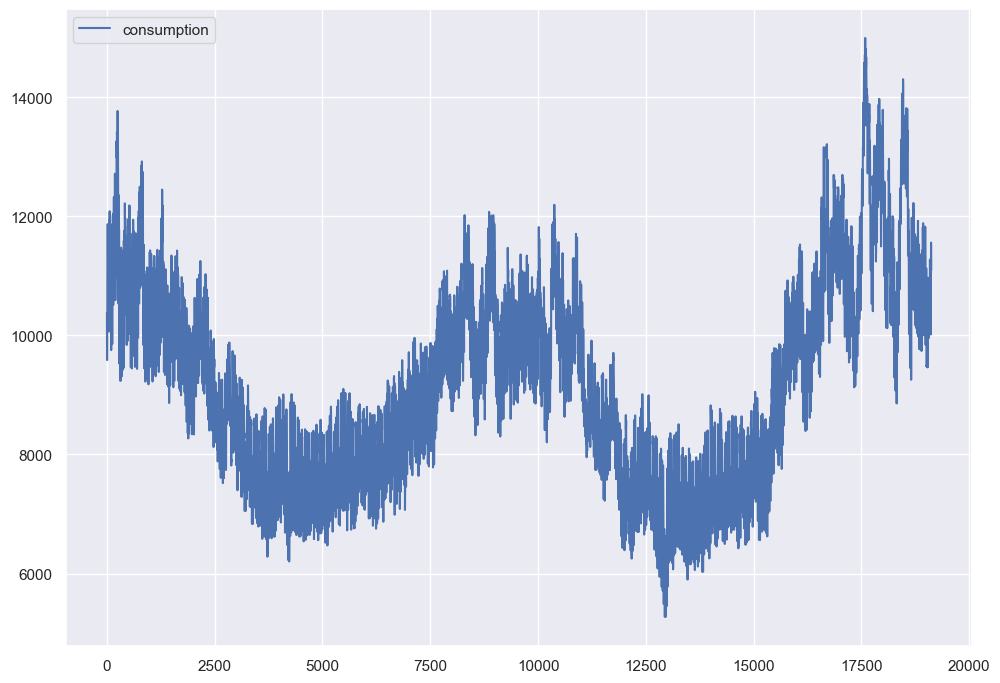

In [3]:
energy_data_years = list(range(2022, 2025))
data = []
for year in energy_data_years:
    with open(f"data/electricity-consumption/{year}.xml", "r") as file:
        data_string = file.read()
        yearly_data = xmltodict.parse(data_string)["GL_MarketDocument"]["TimeSeries"]
        data += yearly_data

energy_data = [day["Period"] for day in data]
hourly_means = {}

times = []
values = []

for day in energy_data:
    time = dt.datetime.strptime(
        day["timeInterval"]["start"], "%Y-%m-%dT%H:%MZ"
    ) + dt.timedelta(hours=2)
    if day["resolution"] == "PT60M":
        for hour in day["Point"]:
            hourly_means[time] = int(hour["quantity"])
            times.append(time)
            values.append(int(hour["quantity"]))
            time += dt.timedelta(hours=1)
    elif day["resolution"] == "PT15M":
        fifteen_min_means = [
            int(fifteen_min["quantity"]) for fifteen_min in day["Point"]
        ]
        i = 0
        while i < len(fifteen_min_means):
            hourly_means[time] = sum(fifteen_min_means[i : i + 4]) / 4
            times.append(time)
            values.append(sum(fifteen_min_means[i : i + 4]) / 4)
            time += dt.timedelta(hours=1)
            i += 4
    else:
        print("Unknown resolution", day["resolution"])

energy_df = pd.DataFrame({"datetime": times, "consumption": values})
# print(energy_df.head())
ax = sns.lineplot(x=energy_df["datetime"], y=energy_df["consumption"])

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Daily energy consumption (MWh)')]

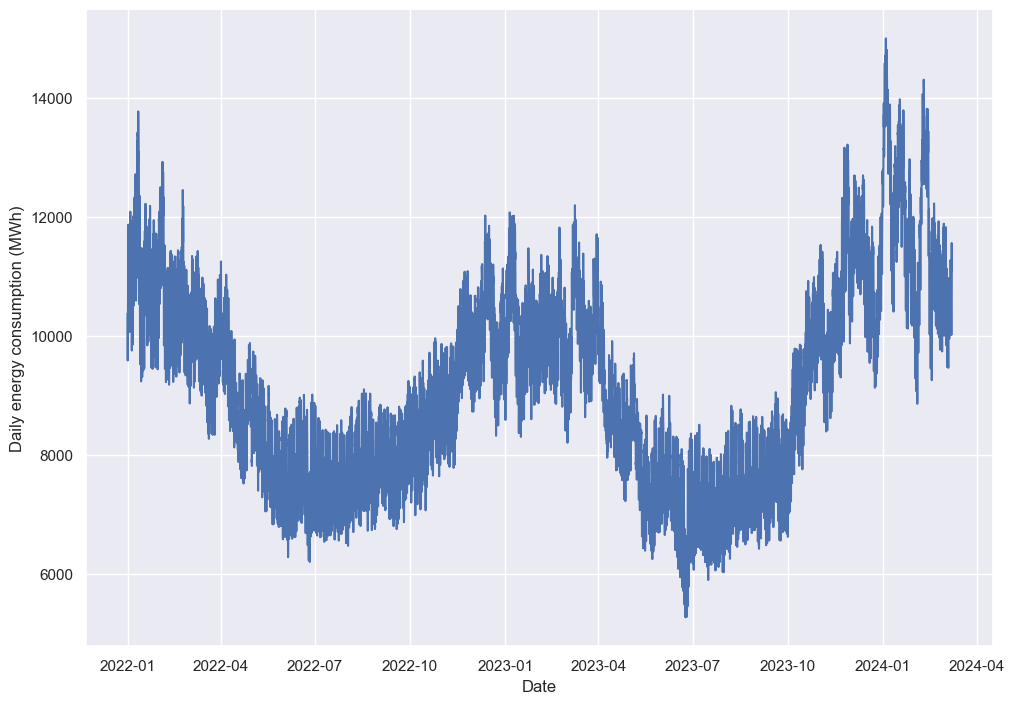

In [18]:
# Polished graph
ax = sns.lineplot(x=energy_df["datetime"], y=energy_df["consumption"])
ax.set(xlabel="Date", ylabel="Daily energy consumption (MWh)")

In [ ]:
# Testing what the get_weather_df gives

start_date = dt.date(2023, 1, 1)
end_date = dt.date(2024, 3, 7)
tw = get_weather_df(start_date, end_date)

In [11]:
tw[1].describe()

,datetime,air temperatures,wind speeds,precipitation amounts
count,10368,10352.000000,10296.000000,10351.000000
mean,2023-08-04 23:30:00,5.333665,3.945037,0.090078
min,2023-01-01 00:00:00,-21.000000,0.200000,0.000000
25%,2023-04-18 23:45:00,-0.800000,2.600000,0.000000
50%,2023-08-04 23:30:00,3.000000,3.800000,0.000000
75%,2023-11-20 23:15:00,14.400000,5.000000,0.000000
max,2024-03-07 23:00:00,27.700000,12.700000,22.900000
std,NaN,9.404787,1.827491,0.557532


# Predictions

Predictions are made with [CatBoost library](https://catboost.ai/).


In [19]:
start_date = dt.date(2024, 1, 1)
end_date = dt.date(2024, 3, 6)

weather_data1 = get_weather_df(start_date, end_date)[1].set_index("datetime")
weather_data2 = get_weather_df(start_date, end_date, "Kajaani")[1].set_index("datetime")
weather_data3 = get_weather_df(start_date, end_date, "Vaasa")[1].set_index("datetime")
dataframe = weather_data1.join(weather_data2, rsuffix="1").join(
    weather_data3, rsuffix="2"
)
dataframe = dataframe.loc[
    :,
    [
        "air temperatures",
        "air temperatures1",
        "air temperatures2",
        "wind speeds",
        "precipitation amounts",
    ],
]
dataframe["weekday"] = dataframe.index.weekday

train_data = dataframe.iloc[: int(0.8 * len(dataframe))]
test_data = dataframe.iloc[int(0.8 * len(dataframe)) :]
train_labels = [hourly_means[time] for time in train_data.index]
train_pool = Pool(train_data, train_labels, cat_features=["weekday"])
test_pool = Pool(test_data, cat_features=["weekday"])

model = CatBoostRegressor(iterations=2, depth=2, learning_rate=1, loss_function="RMSE")
model.fit(train_pool)
predictions = model.predict(test_pool)

print(predictions)

0:	learn: 761.8772807	total: 651us	remaining: 651us
1:	learn: 708.9732908	total: 1.21ms	remaining: 0us
[11172.19266289 11172.19266289 11172.19266289 11172.19266289
 11172.19266289 10620.69251622 10620.69251622 10620.69251622
 10620.69251622 10620.69251622 10620.69251622 10620.69251622
 10620.69251622 10620.69251622 10620.69251622 10620.69251622
 10620.69251622 10620.69251622 10620.69251622 10620.69251622
 10620.69251622 10620.69251622 10620.69251622 10620.69251622
 10620.69251622 10620.69251622 10620.69251622 10620.69251622
 10620.69251622 10620.69251622 10620.69251622 10620.69251622
 10620.69251622 10620.69251622 10620.69251622 10620.69251622
 10620.69251622 10620.69251622 10620.69251622 10620.69251622
 10620.69251622 10620.69251622 10620.69251622 10620.69251622
 10620.69251622 10620.69251622 10620.69251622 10620.69251622
 10620.69251622 10620.69251622 10620.69251622 10620.69251622
 10620.69251622 10620.69251622 10620.69251622 10620.69251622
 10620.69251622 10620.69251622 10620.692516

In [20]:
# forecast accuracy with MAPE

# mape results
# Helsinki 2024: (iterations=2, depth=2, loss_function="RMSE") -> 0.04859686603768826
# 3 weather points 2024: dataset: (18, 1, 'RMSE') = 0.050754643819194256
# 3 weather points 2024 v2: (19, 4, 'RMSE') = 0.05170260585403051

mapes = {}

actual = [hourly_means[time] for time in test_data.index]

for i in range(1, 20):
    for k in range(10):
        for l in ["RMSE", "MAE"]:
            model = CatBoostRegressor(iterations=i, depth=k, loss_function=l)
            model.fit(train_pool)
            predictions = model.predict(test_pool)

            mape = 0
            for p in range(len(predictions)):
                mape += abs((actual[p] - predictions[p]) / actual[p]) / len(predictions)

            # print(f"{mape = }")
            mapes[(i, k, l)] = mape

Learning rate set to 0.5
0:	learn: 1245.2120179	total: 177us	remaining: 0us
0:	learn: 1041.9895412	total: 278us	remaining: 0us
Learning rate set to 0.5
0:	learn: 950.0414841	total: 329us	remaining: 0us
0:	learn: 1021.3430539	total: 403us	remaining: 0us
Learning rate set to 0.5
0:	learn: 909.6731875	total: 997us	remaining: 0us
0:	learn: 1019.8044588	total: 519us	remaining: 0us
Learning rate set to 0.5
0:	learn: 901.0880398	total: 461us	remaining: 0us
0:	learn: 1020.0590208	total: 611us	remaining: 0us
Learning rate set to 0.5
0:	learn: 888.7853863	total: 596us	remaining: 0us
0:	learn: 1019.0164143	total: 527us	remaining: 0us
Learning rate set to 0.5
0:	learn: 890.3289410	total: 1.3ms	remaining: 0us
0:	learn: 1018.8619214	total: 1.37ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 863.1184099	total: 1.93ms	remaining: 0us
0:	learn: 1017.4614992	total: 672us	remaining: 0us
Learning rate set to 0.5
0:	learn: 860.6152442	total: 1.87ms	remaining: 0us
0:	learn: 1017.4547983	total: 1.08ms	re

(1267, 6)
Index(['air temperatures', 'air temperatures1', 'air temperatures2',
       'wind speeds', 'precipitation amounts', 'weekday'],
      dtype='object')
1267
<class 'list'>

2024-2-22 19:00:00
2024-3-6 23:00:00
test data date range
DatetimeIndex(['2024-02-22 19:00:00', '2024-02-22 20:00:00',
               '2024-02-22 21:00:00', '2024-02-22 22:00:00',
               '2024-02-22 23:00:00', '2024-02-23 00:00:00',
               '2024-02-23 01:00:00', '2024-02-23 02:00:00',
               '2024-02-23 03:00:00', '2024-02-23 04:00:00',
               ...
               '2024-03-06 14:00:00', '2024-03-06 15:00:00',
               '2024-03-06 16:00:00', '2024-03-06 17:00:00',
               '2024-03-06 18:00:00', '2024-03-06 19:00:00',
               '2024-03-06 20:00:00', '2024-03-06 21:00:00',
               '2024-03-06 22:00:00', '2024-03-06 23:00:00'],
              dtype='datetime64[ns]', length=317, freq='h')
317

<class 'list'>
317
317


/var/folders/l4/qrxkndm53b727qyfv3zzqrjr0000gq/T/ipykernel_81572/1717172538.py:7: FutureWarning: first is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  test_data_start_date = f'{test_data.first("1H").index.year[0]}-{test_data.first("1H").index.month[0]}-{test_data.first("1H").index.day[0]} {test_data.first("1H").index.hour[0]}:00:00'
/var/folders/l4/qrxkndm53b727qyfv3zzqrjr0000gq/T/ipykernel_81572/1717172538.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  test_data_start_date = f'{test_data.first("1H").index.year[0]}-{test_data.first("1H").index.month[0]}-{test_data.first("1H").index.day[0]} {test_data.first("1H").index.hour[0]}:00:00'
/var/folders/l4/qrxkndm53b727qyfv3zzqrjr0000gq/T/ipykernel_81572/1717172538.py:8: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  test_data_end_date = f'{t

[Text(0.5, 0, 'Datetime'), Text(0, 0.5, 'Energy consumption (MWh)')]

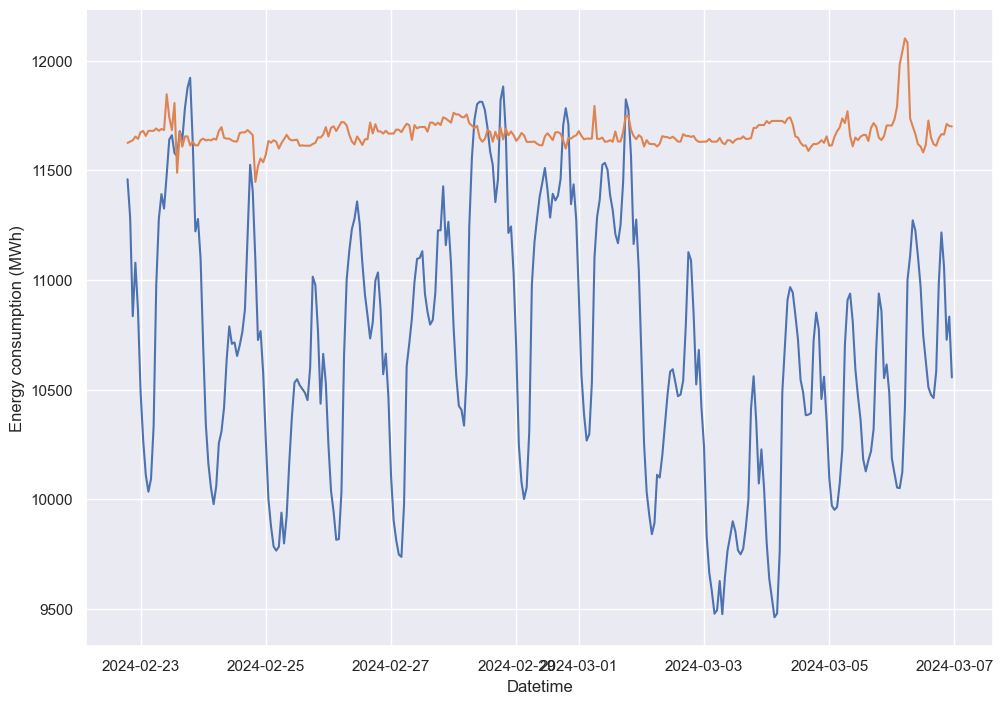

In [60]:
print(train_data.shape)
print(train_data.columns)
print(len(train_labels))
print(type(train_labels))
print()

test_data_start_date = f'{test_data.first("1H").index.year[0]}-{test_data.first("1H").index.month[0]}-{test_data.first("1H").index.day[0]} {test_data.first("1H").index.hour[0]}:00:00'
test_data_end_date = f'{test_data.last("1H").index.year[0]}-{test_data.last("1H").index.month[0]}-{test_data.last("1H").index.day[0]} {test_data.last("1H").index.hour[0]}:00:00'
print(test_data_start_date)
print(test_data_end_date)

print("test data date range")
dr = pd.date_range(test_data_start_date, test_data_end_date, freq="H")
print(dr)
print(len(dr))
print()
print(type(actual))
print(len(actual))
print(len(predictions))


ax = sns.lineplot(x=dr, y=actual)
ax = sns.lineplot(x=dr, y=predictions)
ax.set(xlabel="Datetime", ylabel="Energy consumption (MWh)")

In [21]:
# locate the smallest mean absolute percentage error

print(f"{min(mapes, key=mapes.get)} = {mapes[min(mapes, key=mapes.get)]}")

(19, 4, 'RMSE') = 0.05170260585403051


In [ ]:
# joining the weather and consumption data

train_weather = get_weather_df(dt.date(2023, 1, 1), dt.date(2023, 12, 31))[1]

train_data = train_weather.set_index("datetime").join(energy_df.set_index("datetime"))